In [1]:
import numpy as np
import scipy.io
import networkx as nx
import pandas as pd
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

### Use Dandi to access data via the internet

In [2]:
from dandi.dandiapi import DandiAPIClient

import fsspec
import pynwb
from pynwb import NWBHDF5IO
import h5py
from fsspec.implementations.cached import CachingFileSystem

In [3]:
def get_dandi_asset_paths(dataset_id, version="draft"):
    paths = []
    with DandiAPIClient() as client:
        d = client.get(f"/dandisets/{dataset_id}/versions/{version}/assets/")
        for asset in d["results"]:
            paths.append(asset["path"])
    return sorted(paths)

In [4]:
print(len(get_dandi_asset_paths("000541")))
print(get_dandi_asset_paths("000541"))

A newer version (0.56.2) of dandi/dandi-cli is available. You are using 0.56.1


21
['sub-20190924-01/sub-20190924-01_ses-20190924_ophys.nwb', 'sub-20190924-02/sub-20190924-02_ses-20190924_ophys.nwb', 'sub-20190924-03/sub-20190924-03_ses-20190924_ophys.nwb', 'sub-20190925-01/sub-20190925-01_ses-20190925_ophys.nwb', 'sub-20190925-04/sub-20190925-04_ses-20190925_ophys.nwb', 'sub-20190928-01/sub-20190928-01_ses-20190928_ophys.nwb', 'sub-20190928-03/sub-20190928-03_ses-20190928_ophys.nwb', 'sub-20190928-05/sub-20190928-05_ses-20190928_ophys.nwb', 'sub-20190928-07/sub-20190928-07_ses-20190928_ophys.nwb', 'sub-20190928-08/sub-20190928-08_ses-20190928_ophys.nwb', 'sub-20190928-11/sub-20190928-11_ses-20190928_ophys.nwb', 'sub-20190928-13/sub-20190928-13_ses-20190928_ophys.nwb', 'sub-20190929-02/sub-20190929-02_ses-20190929_ophys.nwb', 'sub-20190929-03/sub-20190929-03_ses-20190929_ophys.nwb', 'sub-20190929-05/sub-20190929-05_ses-20190929_ophys.nwb', 'sub-20190929-06/sub-20190929-06_ses-20190929_ophys.nwb', 'sub-20190929-07/sub-20190929-07_ses-20190929_ophys.nwb', 'sub-20191

In [5]:
# Source: https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html#streaming

# first, create a virtual filesystem based on the http protocol
fs = fsspec.filesystem("http")

# create a cache to save downloaded data to disk (optional)
fs = CachingFileSystem(
    fs=fs,
    cache_storage="nwb-cache",  # Local folder for the cache
)

In [6]:
def get_dandi_and_do(dandiset_id, filepath, do_this=lambda x : None):
    # Source: https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html#streaming
    # Docs: https://dandi.readthedocs.io/en/stable/modref/dandiapi.html
    
    with DandiAPIClient() as client:
        asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
        s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

    # next, open the file
    with fs.open(s3_url, "rb") as f:
        with h5py.File(f) as file:
            with pynwb.NWBHDF5IO(file=file, load_namespaces=True) as io:
                nwbfile = io.read()
                output = do_this(nwbfile)

    return output

In [7]:
def get_dandi_data(dandiset_id, filepath, data_slice=slice(None), do_this=lambda x : None):
    return get_dandi_and_do(dandiset_id, filepath, lambda nwbfile : np.array(nwbfile.acquisition["CalciumImageSeries"].data[data_slice]))

In [8]:
data = get_dandi_data("000541", get_dandi_asset_paths("000541")[3], (slice(300,320),slice(100,120),slice(100,120),0))
print(data.any())

/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


False


In [9]:
for asset_path in get_dandi_asset_paths("000541")[:5]:
    shape = get_dandi_and_do("000541", asset_path, lambda nwbfile: nwbfile.acquisition["CalciumImageSeries"].data.shape)
    print(shape)

(962, 256, 128, 21)
(962, 256, 128, 21)
(963, 256, 128, 21)
(963, 256, 128, 21)
(961, 256, 128, 21)


In [10]:
# I kept getting 0s in the data so I picked a random data set and checked if it contains a single non-zero value. 
# This had the added benefit of caching the entire timeseries for asset 4, so I'll be using the 4th asset from now on for no reason other than that I have it cached already.

nonzero = get_dandi_and_do("000541", get_dandi_asset_paths("000541")[4], lambda nwbfile: np.array(nwbfile.acquisition["CalciumImageSeries"].data).any())
print(nonzero)

True


### Load in connectome information (neuron names and weighted directed graph of synapses)

In [11]:
male_chemical_connectome = pd.read_excel("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male chemical")

In [12]:
print(male_chemical_connectome.values[1:20,2:10])
print(np.isnan(male_chemical_connectome.values[0,0]))

[[nan 'I1L' 'I1R' 'I2L' 'I2R' 'I3' 'I4' 'I5']
 ['I1L' nan nan 10 nan 3 nan 2]
 ['I1R' nan nan nan 6 1 nan 2]
 ['I2L' 2 nan nan 3 nan 13 2]
 ['I2R' nan 1 3 nan nan 20 2]
 ['I3' 1 1 nan nan nan nan 2]
 ['I4' nan nan nan 7 nan nan 2]
 ['I5' 2 nan 3 1 1 7 nan]
 ['I6' nan 1 1 4 12 nan nan]
 ['M1' nan 1 3 2 8 1 2]
 ['M2L' nan nan nan nan 2 8 2]
 ['M2R' nan nan nan nan nan 1 3]
 ['M3L' nan nan nan nan nan nan nan]
 ['M3R' nan nan nan nan nan nan nan]
 ['M4' nan nan nan nan nan 5 1]
 ['M5' nan nan nan nan nan nan 1]
 ['MCL' nan nan nan nan nan nan nan]
 ['MCR' nan nan nan nan nan nan nan]
 ['MI' 1 nan nan nan 2 1 nan]]
True


In [13]:
table = male_chemical_connectome.values[1:,2:]

In [14]:
print(table[270:400,0])
print(table[0,1:10])

['VB02' 'VB03' 'VB04' 'VB05' 'VB06' 'VB07' 'VB08' 'VB09' 'VB10' 'VB11'
 'VD01' 'VD02' 'VD03' 'VD04' 'VD05' 'VD06' 'VD07' 'VD08' 'VD09' 'VD10'
 'VD11' 'VD12' 'VD13' 'CEMDL' 'CEMDR' 'CEMVL' 'CEMVR' 'MCML' 'MCMR' 'R1AL'
 'R1AR' 'R1BL' 'R1BR' 'R2AL' 'R2AR' 'R2BL' 'R2BR' 'R3AL' 'R3AR' 'R3BL'
 'R3BR' 'R4AL' 'R4AR' 'R4BL' 'R4BR' 'R5AL' 'R5AR' 'R5BL' 'R5BR' 'R6AL'
 'R6AR' 'R6BL' 'R6BR' 'R7AL' 'R7AR' 'R7BL' 'R7BR' 'R8AL' 'R8AR' 'R8BL'
 'R8BR' 'R9AL' 'R9AR' 'R9BL' 'R9BR' 'PHDL' 'PHDR' 'HOA' 'HOB' 'PCAL'
 'PCAR' 'PCBL' 'PCBR' 'PCCL' 'PCCR' 'SPCL' 'SPCR' 'SPDL' 'SPDR' 'SPVL'
 'SPVR' 'PVV' 'PVX' 'PVY' 'PVZ' 'DVE' 'DVF' 'DX1' 'DX2' 'DX3' 'EF1' 'EF2'
 'EF3' 'PDC' 'PGA' 'CA01' 'CA02' 'CA03' 'CA04' 'CA05' 'CA06' 'CA07' 'CA08'
 'CA09' 'CP01' 'CP02' 'CP03' 'CP04' 'CP05' 'CP06' 'CP07' 'CP08' 'CP09' nan]
['I1L' 'I1R' 'I2L' 'I2R' 'I3' 'I4' 'I5' 'I6' 'M1']


In [15]:
neuron_names = set().union(table[1:,0], table[0,1:])
neuron_names = {x for x in neuron_names if x == x} #remove nans
neuron_names = sorted(list(neuron_names))

In [16]:
print(neuron_names[:10])

['ADAL', 'ADAR', 'ADEL', 'ADER', 'ADFL', 'ADFR', 'ADLL', 'ADLR', 'AFDL', 'AFDR']


In [17]:
edge_list = []

def isnan(x):
    return isinstance(x, float) and np.isnan(x)

for r in range(1,len(table)):
    for c in range(1,len(table[r])):
        if isnan(table[r][c]) or isnan(table[r][0]) or isnan(table[0][c]):
            continue
        edge_list.append((table[r][0], table[0][c], table[r][c]))

In [18]:
print(edge_list[:10])

[('I1L', 'I2L', 10), ('I1L', 'I3', 3), ('I1L', 'I5', 2), ('I1L', 'I6', 1), ('I1L', 'M2L', 3), ('I1L', 'M3L', 8), ('I1L', 'M3R', 2), ('I1L', 'MCL', 2), ('I1L', 'MCR', 2), ('I1L', 'MI', 2)]


In [19]:
connectome = nx.DiGraph()
connectome.add_weighted_edges_from(edge_list)

In [20]:
print(next(connectome.adjacency()))
test_neuron = "MCL"
print(list(connectome.neighbors(test_neuron)))
print(list(connectome.successors(test_neuron)))
print(list(connectome.predecessors(test_neuron)))


('I1L', {'I2L': {'weight': 10}, 'I3': {'weight': 3}, 'I5': {'weight': 2}, 'I6': {'weight': 1}, 'M2L': {'weight': 3}, 'M3L': {'weight': 8}, 'M3R': {'weight': 2}, 'MCL': {'weight': 2}, 'MCR': {'weight': 2}, 'MI': {'weight': 2}, 'NSML': {'weight': 3}, 'pm1': {'weight': 2}, 'pm3VL': {'weight': 7}, 'pm4D': {'weight': 1}, 'pm4VL': {'weight': 2}})
['mc2DR', 'mc2V']
['mc2DR', 'mc2V']
['I1L', 'I1R', 'I2R', 'I3', 'M4', 'MI']


### Load in neuron traces

In [21]:
traces = scipy.io.loadmat('datasets/1554.mat') # These are traces from rat brains. Do not use for anything other than testing.

In [22]:
print(np.shape(traces.get("rawdata")))
print(traces.get("rawdata")[:,5])
print(len(traces.get("rawdata")[:,5]))

(125000, 6)
[ 0.016398  0.018987  0.021252 ... -0.140231 -0.143467 -0.145085]
125000


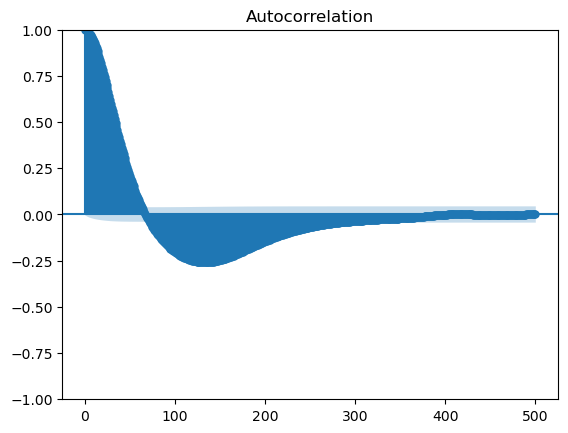

In [23]:
plot_acf(traces.get("rawdata")[:,5], lags=500)
pyplot.show()

In [24]:
# fake data (just for testing optimization - results from this are meaningless)

def get_fake_trace():
    channel = np.random.randint(1,6)
    return traces.get("rawdata")[:,channel]

fake_traces = {}
for neuron in neuron_names:
    fake_traces[neuron] = get_fake_trace()

In [25]:
print(fake_traces['I1L'][:10])
print(type(fake_traces['I1L'][:10]))

[0.01195  0.013567 0.015831 0.017124 0.018094 0.019388 0.020682 0.022298
 0.023592 0.025209]
<class 'numpy.ndarray'>


In [26]:
DEFAULT_WINDOW_WIDTH = 20
DEFAULT_SELF_RETENTION = 1      # 0 corresponds with completely linear

In [27]:
def get_relevant_neurons(neuron):
    return sorted(list(set().union([neuron], connectome.successors(neuron), connectome.predecessors(neuron))))

In [28]:
print(len(get_relevant_neurons(test_neuron)))
print(get_relevant_neurons(test_neuron))

9
['I1L', 'I1R', 'I2R', 'I3', 'M4', 'MCL', 'MI', 'mc2DR', 'mc2V']


In [29]:
def get_relevant_history_vector(traces, neuron, t, w=DEFAULT_WINDOW_WIDTH):
    if t-w < 0:
        raise ValueError(f'Cannot construct large enough relevant history vector: time t = {t} is too early.')
    relevant_neurons = get_relevant_neurons(neuron)
    history = np.concatenate([traces[n][t-w:t] for n in relevant_neurons])
    return history

In [30]:
print(len(get_relevant_history_vector(fake_traces, test_neuron, 100)))
print(get_relevant_history_vector(fake_traces, test_neuron, 100))

180
[0.037174 0.036528 0.034911 0.033294 0.031677 0.030707 0.028766 0.027796
 0.027149 0.026503 0.025856 0.025209 0.024562 0.023915 0.023592 0.022945
 0.022945 0.023269 0.023915 0.024562 0.062037 0.058155 0.054272 0.05136
 0.048125 0.045213 0.042301 0.039066 0.03583  0.032271 0.029036 0.02483
 0.021918 0.019006 0.016418 0.013506 0.010594 0.007358 0.004123 0.000887
 0.01834  0.016398 0.014457 0.012515 0.010573 0.008632 0.007337 0.00669
 0.00669  0.00669  0.007337 0.007337 0.007013 0.006366 0.005719 0.004101
 0.00313  0.002159 0.002159 0.002159 0.062037 0.058155 0.054272 0.05136
 0.048125 0.045213 0.042301 0.039066 0.03583  0.032271 0.029036 0.02483
 0.021918 0.019006 0.016418 0.013506 0.010594 0.007358 0.004123 0.000887
 0.135818 0.140024 0.143584 0.146172 0.148114 0.148761 0.148114 0.146172
 0.14326  0.140995 0.137759 0.134523 0.13064  0.125139 0.119315 0.110902
 0.100547 0.088898 0.077572 0.067217 0.01834  0.016398 0.014457 0.012515
 0.010573 0.008632 0.007337 0.00669  0.00669  0.0066

In [31]:
def get_self_retention_vector(traces, neuron, t, r=DEFAULT_SELF_RETENTION):
    if t-r < 0:
        raise ValueError(f'Cannot construct large enough self-retention vector: time t = {t} is too early.')
    return np.concatenate(([1],traces[neuron][t-r:t]))

In [32]:
print(get_self_retention_vector(fake_traces, test_neuron, 100))

[1.       0.002159]


In [33]:
def next_value(update_matrix, traces, neuron, t, w=DEFAULT_WINDOW_WIDTH, r=DEFAULT_SELF_RETENTION):
    rhv = get_relevant_history_vector(traces, neuron, t, w)
    srv = get_self_retention_vector(traces, neuron, t, r)
    if update_matrix.shape != (len(rhv),len(srv)):
        raise ValueError(f'Update failed for neuron {neuron} at time t = {t}: Update matrix has shape {update_matrix.shape} but needs shape {(len(rhv),len(srv))}.')
    return rhv @ update_matrix @ srv.T

In [34]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([1,2])
c = np.array([1,2,3])
print(b @ a @ c.T)

78


In [35]:
update_matrix = np.ones((180,2))
next_value(update_matrix, fake_traces, test_neuron, 100)

8.535194786313001